# Diagnosing chicken disease from photos of their faeces 

## 1. Background

There are approximately 124 million broiler chickens in the UK and 14 million laying hens. Chickens have one of the highest feed converion efficiencies of all farmed animals and provide a large proportion of the UK's animal protein. Commercial production is based on very fine margins and so any ineffiencies must be minimised other profitability is rapidly reduced. As such these birds are kept to very high health standards and any suspicion of disease must be rapidly investigated in order to impliment the correct control measures.
Three such diseases that are of concern to the international poultry industry are:


1.   Newcastle disease :  This is a viral disease that can cause a wide variety of symptoms including high mortality, diarrhoea and respiratory distress. It is potentially zoonotic, although normally very mild. It hasn't been confirmed in the UK since 2006 and is a notificable disease.
2.   Salmonella : This is a bacterial disease, that can cause minor symptoms in chickens including weakness and diarrhoea. It of most note though because it is zoonotic and may cause serious illness in humans through contaminated meat or eggs.
3. Coccidiosis: This is a protozoal disease of birds that unlike the previous two is not zoonotic but can cause serious disease in flocks. Its main symptoms are severe diarrhoea, high mortaltily and reduced intakes and production.

Of note with all these diseases is that they can cause diarrhoea in birds. At the minute when changes to faecal consistency is noted in flocks extensive microbiological testing is performed in order to identify the cause. This process takes at least 24hours normally and so if there were a way to speed up diagnosis it would allow for corrective action to be taken sooner minimising the impact. 

Artifical inteligence and deep learning has been used previously to try and identify the disease a chicken is suffering from using pictures of the bird (Quach et al. 2022) with an accuracy of 94%. This idea is explored further in this paper by testing if a model can be developed that can identify if newcastle disease (NCD), salmonella or coccidiosis is present or if the animal was healthy by using pictures of the birds faeces. 






## 2. Methods

### 2.1 Data preparation

The data for this project was sourced from Kaggle. The dataset contains 8067 jpg files that were taken with mobile phones in Tanzania between 2020-2021. The images are labeled as being from birds that are either healthy or infected with Salmonella, Coccidiosis or Newcastle Disease. The number of images in each category are shown in the table below along with the data counts after performing a 80/10/10 split for the final model. 

Classification | Test  | Train | Validate | Total
-------------------|------------------|-------------------|---------|---------
Healthy      | 241 | 1923  |240 |2404
Salmonella      | 263 | 2100  | 262 |2625
Newcastle Disease     | 57 | 449 | 56 | 562
Coccidiosis    | 249 | 1980 | 247 | 2476

The following code chunk installs the required packages for processing the data, creating the model and visualing the results

In [ ]:
## Setting seed for reproducability 

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

## Setting up required packages
!pip install split-folders

import os
import os.path
import shutil
import splitfolders
import warnings
import matplotlib.pyplot as plt
import matplotlib.text as txt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
from pandas import DataFrame
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.layers.experimental import preprocessing
from google.colab import files
from keras.layers.rnn import time_distributed
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import EfficientNetB3

The data is downloaded and processed into a format ready for use in keras to train, test and validate the models using the following 3 custom functions.
The get_data() function downloads the data from kaggle, and splits it into train, test, and validate folders using a default split of 80/10/10. The data_size() funtion uses the keras function 'image_dataset_from_directory' to return autotuned variables of the respective datasets while allowing the batch size and pixel size to be altered.

In [ ]:
def mergefolders(root_src_dir, root_dst_dir): # create function to merge folders
    """
    Merges two folders into one
    root_src_dir: str - origin folder
    root_dst_dir: str - destination folder
    
    """
    for src_dir, dirs, files in os.walk(root_src_dir):
          dst_dir = src_dir.replace(root_src_dir, root_dst_dir, 1)
          if not os.path.exists(dst_dir):
              os.makedirs(dst_dir)
          for file_ in files:
              src_file = os.path.join(src_dir, file_)
              dst_file = os.path.join(dst_dir, file_)
              if os.path.exists(dst_file):
                  os.remove(dst_file)
              shutil.copy(src_file, dst_dir)


In [ ]:
def get_data(test = 0.1, train = 0.8, validate = 0.1):
  
  """
  Removes any previously downloaded data then downloads 'chicken-disease-1' data from kaggle.
  Splits data into seperate folders based on disease, then splits data into 
  test, train and validate using a default of 80/10/10

    test: float - proportion of data to be partitioned into test data
    train: float - proportion of data to be partitioined into training data
    validate: float - proportion of data to be partitioned into validation data
    
    """

 # remove any previously downloaded data
  !rm -rf '/content/Train'
  !rm -rf '/content/train_data.csv'
  !rm -rf '/content/output'
  !rm -rf '/content/chicken-disease-1 .zip'

  !kaggle datasets download -d 'allandclive/chicken-disease-1 ' -p /content #download data
  !unzip -qq 'chicken-disease-1 .zip' # unzip data
  

  folder_path = '/content/Train' # Set path where images are

# create list of images to go through below
  images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

  for image in images:
    folder_name = image.split('.')[0] # Creates folder based on first part of name

    new_path = os.path.join(folder_path, folder_name) # creates new path name
    if not os.path.exists(new_path): # checks if path exixts
      os.makedirs(new_path)  # if doesn't exists creates it

    old_image_path = os.path.join(folder_path, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path) # moves picture


  # merge all folders with similar contents

  mergefolders('/content/Train/pcrcocci', '/content/Train/cocci')
  mergefolders('/content/Train/pcrsalmo', '/content/Train/salmo')
  mergefolders('/content/Train/pcrncd', '/content/Train/ncd')
  mergefolders('/content/Train/pcrhealthy', '/content/Train/healthy')

  # remove folders not needed

  !rm -rf '/content/Train/pcrsalmo'
  !rm -rf '/content/Train/pcrncd'
  !rm -rf '/content/Train/pcrhealthy'                    
  !rm -rf '/content/Train/pcrcocci'

  # Check folder counts
  print(f"cocci {len(os.listdir('/content/Train/cocci'))}")
  print(f"healthy {len(os.listdir('/content/Train/healthy'))}")
  print(f"ncd {len(os.listdir('/content/Train/ncd'))}")
  print(f"salmonella {len(os.listdir('/content/Train/salmo'))}")

  # split data into test, train and validate partitions 

  splitfolders.ratio('Train', output="output", seed=1337, ratio=(train,test,validate))


In [ ]:
def data_size(pixel_size = 224, batch_size = 128):
  """
    Create variables with the ready split data
    Allows the pizel size and batch size to be set
    Autotunes the data to allow increased model speed
    Returns three variables in the order train, test and validate

    pixel_size: int - Single number (x) which is used to set the pixel size of the image to (x,x)
    batch_size: int - Size of batch of images for training the model
    """
# creates variable with pixel size and batch size altered 
  ds_train_ = image_dataset_from_directory(
      '/content/output/train', # sets source of images
      labels='inferred', # infers labels from folder names
      label_mode='categorical',
      image_size=[pixel_size, pixel_size], # allows pixel size to be altered by function call
      interpolation='nearest',
      batch_size=batch_size, # allows batch size to be altered by function call
      shuffle=True,
  )

  ds_valid_ = image_dataset_from_directory(
      '/content/output/val', # sets source of images
      labels='inferred',
      label_mode='categorical',
      image_size=[pixel_size, pixel_size], # allows pixel size to be altered by function call
      interpolation='nearest',
      batch_size=batch_size, # allows batch size to be altered by function call
      shuffle=False,
  )

  ds_test_ = image_dataset_from_directory(
      '/content/output/test', # sets source of images
      labels='inferred',
      label_mode='categorical',
      image_size=[pixel_size, pixel_size],# allows pixel size to be altered by function call
      interpolation='nearest',
      batch_size= batch_size, # allows batch size to be altered by function call
      shuffle=False,
  )
  
  # Autotunes the data to allow for faster model processing
  AUTOTUNE = tf.data.AUTOTUNE

  ds_train_ = ds_train_.cache().prefetch(buffer_size=AUTOTUNE)
  ds_test_ = ds_test_.cache().prefetch(buffer_size=AUTOTUNE)
  ds_valid_ = ds_valid_.cache().prefetch(buffer_size=AUTOTUNE)
 
  return [ds_train_, ds_test_, ds_valid_]

The first step in accessing the data from kaggle is to upload a kaggle.json file accessible from your kaggle account. An explainer of how to access this can be found on the [kaggle website](https://www.kaggle.com/general/74235). Once the file has been uploaded then the get_data() function can be run to download the data.

In [ ]:
## Need to add kaggle.json file to allow data download from kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
get_data() # Run Previously created function to download and split data


The downloaded images can be visualised below to check that they have been downloaded correctly and are labelled.

In [ ]:
# Create a vector of just the training dataset
ds_train_ = image_dataset_from_directory(
      '/content/output/train',
      labels='inferred',
      label_mode='categorical',
      image_size=[224,224],
      interpolation='nearest',
      batch_size=32,
      shuffle=True,
  )

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells
class_names = ds_train_.class_names

plt.figure(figsize=(10, 10))
for images, labels in ds_train_.take(1):
  for i in range(9): # select 9 images to show below
    numpy_labels = labels.numpy()
    x = (np.where(numpy_labels[i]==1)[0])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(x)])
    plt.axis("off")
  

The three variables of train, test and validate can then be created using the data_size() function created earlier. By default the batch size is 128, and pixel size is (224,224)

In [ ]:
ds_train_, ds_test_, ds_valid_ = data_size(batch_size = 32)


### 2.2 Build basic model

A initial model was built using the keras sequential frameework. It included 2D convolutional layers with a 3x3 kernel size alternating with 2D max pooling layers. A Rectifified Linear Unit (relu) activation function was included with the convolutional layers as it allows complex non-linear relationships in the data to be learned.

In compiling the model the 'adam' optimiser was used (Kingma and Ba, 2015) as it is simple to work with and has been shown to produce good results. The loss used is 'categorical_crossentropy', and the metric used 'accuracy'.

In [ ]:
model = tf.keras.Sequential([ # create a model using keras sequential
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape = (224,224,3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(4, activation = 'softmax')
])

In [ ]:
# compiling the model using the adam optimiser
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
# Training the model over 10 epochs using the training data
history = model.fit(
  ds_train_,
  validation_data=ds_valid_,
  epochs=10
)

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

This initial model after 5 epochs achieves a validation accuracy of 0.90 with a validation loss of 0.31. After these 5 epochs the validation loss starts to increase and the validation accuracy starts to increase suggesting that the model is overfitting. 

These initial results appear promising as the model required minimal training and had reasonable results.

### 2.3 Pretrained base selection

Three different pretrained bases were used to perform feature extraction as it can be a relatively fast way in improve the accuracy of a model (Brodzicki et al., 2020). In order to ensure that the weights that have already been learned in training were retained all layers of the pretrained based were set to be non-trainable. The pretrained bases were attached to a simple head and then trained using the training data over 10 epochs to measure which provided the best performance.

In [ ]:
# load model
VGG = VGG16(include_top=False, weights='imagenet', input_shape = (224,224,3))
VGG.trainable = False # set to non-trainable

In [ ]:
# load model
inception = InceptionV3(include_top = False, input_shape = (224,224,3) )

inception.trainable = False# set to non-trainable


In [ ]:
# load model
efficientnet = EfficientNetB3(include_top = False, weights='imagenet',input_shape = (224,224,3))

efficientnet.trainable = False# set to non-trainable

In [ ]:
def make_model(data = True, graph = True, pretrained_base = inception, epoch = 10):
  """
  Function to train a compiled model incorporating a pretrained_base and a 
  small head. It is compiled using the adam optimiser.

  data: bool - If the history information should be printed, default is true
  graph: bool - If the val_accuracy and val_loss graphs should be printed,
  default is True
  pretrained_base: str - Can be set to any pretrained base, defaults to Inception V3
  epoch: int - number of epochs for the model to run for

  """

  pretrainedbase = pretrained_base # use pretrained base as specified in the function call
  
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255), # normalising the data 
    pretrainedbase, # using the pretrained base
    layers.Flatten(),
    # simple head for model
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
  # compliling the model using adam optimiser
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
# training the model over the number of epochs specified in function call
  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=epoch,
    verbose = 0
  )
  history_frame = pd.DataFrame(history.history)
  
# if requested in function call printing results
  if data == True:
    print(history_frame)

# if requested in function call visualsing loss and accuracy
  if graph == True:
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

  return history

In [ ]:
# making model with VGG base
VGG_history = make_model(pretrained_base = VGG)

In [ ]:
#making model with inception base
inception_history = make_model(pretrained_base = inception)

In [ ]:
# making model with efficientnet base
efficientnet_history = make_model(pretrained_base = efficientnet)

The models used as the pretrained base were EfficientNetB3, Inception V3 and the VGG16. The IncpetionV3 model had the best validation accuracy and so was selected to be used in all later models. The VGG16 model had equivalent performance to my basic model over this low number of epochs but didn't appear to be overfit so may still have improved its performance. Surprisingly the EfficientNetB3 didn't come close the to accuracy of the baseline model.

 . | Val_loss  | Val_accuracy | Epoch 
-------------------|------------------|-------------------|---------
EfficientNetB3    | 1.17 | 0.53  |8
InceptionV3     | 0.38 | 0.92  | 10
VGG16     | 0.37 | 0.89 | 8


### 2.4 Batch size

All previous models have been tested using a batch size of 32. In order to fine tune this hyperparameter a grid search was performed with a batch size of 2, 4, 8, 16, 32, 64, 128, 256, 512 and 1024.

Small batch sizes have been recommended by Wilson & Martinez (2003) for their regularisation effect but Smith (2018) recommends a larger batch size to maximise test performance while minimising the computational time. Larger batch sizes over the same number of epochs as a smaller batch size require less time to run and so less compuational time but they may exceed the computational power of the hardware.

The make_model() function created earlier was used to allow for repeated models to be created and trained to measure the validation accurracy and loss as well as the time taken to run 10 epochs for varying batch sizes


In [ ]:
batches = [2,4,8,16,32,64,128,256,512,1024] # Set batch sizes to be tested
val_loss = {} # create empty dictionary to save val_loss to
val_accuracy = {} # create empty dictionary to save val_accuracy to
times = {} # create empty dictionary to save time taken to run to

for bs in batches:
  start = time.time() # start timer
  print(bs)
  ds_train_, ds_test_, ds_valid_ = data_size(batch_size = bs) # Create datasets in correct batch size
  history = make_model(False, False) # train model
  end = time.time() # stop timer
  val_accuracy[bs] = round(max(history.history['val_accuracy']),3) # Save best val_accuracy
  val_loss[bs]= round(min(history.history['val_loss']),3) # save best val_loss
  times[bs] = round(end-start) # save time taken to train model 


In [ ]:
# Plot val_accuracy 

names = [str(i) for i in (list(val_accuracy.keys()))] # create vector of batch size tested
values = list(val_accuracy.values()) # create vector of val_accuracy values

plt.plot( names, values) # create plot of val_accuracy
plt.title('Val_accuracy')
plt.show()

# Plot val_loss

names = [str(i) for i in (list(val_loss.keys()))] # create vector of batch size tested
values = list(val_loss.values()) # create vector of val_loss values

plt.plot( names, values) # create plot
plt.title('Val_loss')
plt.show()

# Plot Time taken
names = [str(i) for i in (list(times.keys()))] #  create vector of batch size tested
values = list(times.values()) # create vector of time values

plt.plot( names, values) # Create plot
plt.title('Time')
plt.show()

A batch size of 128 was selected for inclusion in the final model using this data as it had the joint highest validation accuracy, the 3rd lowest validation loss and the shortest time. A new model was created using this batch size over 10 epochs to create a new baseline.

In [ ]:
# view validation accuracy for different batch sizes
val_accuracy

In [ ]:
# view validation loss for different batch sizes
val_loss

In [ ]:
# view time taken for different batch sizes
times

In [ ]:
## model for future comparison
get_data()
ds_train_, ds_test_, ds_valid_ = data_size(batch_size = 128) # using the optimum batch size
history = make_model()

This model has a maximum validation accuracy of 0.929 and a validation loss 0.282. 

### 2.5 Data Augmentation

Data augmentation involves adding random transformations to the data before it is input into the model. This step helps to avoid overfitting to the data (Mikołajczyk and Grochowski, 2018). and is especially useful with smaller datasets such as this one. The augmentations included were RandomFlip (both horizonal and vertical), RandomZoon, RandomRotation and RandomTranslation.

In [ ]:
# create a data augmentation layer to include in models
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomZoom(0.2),
        layers.RandomRotation(factor = 0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ])

In [ ]:
#Updating the make model function to include the option to have data augmentation

def make_model(data = True, graph = True, pretrained_base = inception, epoch = 10, augmentation = False):
  """
  Function to train a compiled model incorporating a pretrained_base and a 
  small head. It is compiled using the adam optimiser.

  data: bool - If the history information should be printed, default is true
  graph: bool - If the val_accuracy and val_loss graphs should be printed,
  default is True
  pretrained_base: str - Can be set to any pretrained base, defaults to Inception V3
  epoch: int - number of epochs for the model to run for

  """

  pretrainedbase = pretrained_base # selecting pretrained base from function call

  if augmentation == False: # If augmentation is false then don't include it in model
    model = keras.Sequential([
      tf.keras.layers.Rescaling(1./255),
      pretrainedbase,
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(4, activation='softmax'),
    ])

  elif augmentation == True: # if augmentation is True then include it in the model
    model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    pretrained_base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
    
  else: # if anything else then return error message but still run model using defualt False
    print("Invalid arguement for augmentation. \n 'True' or 'False' are only valid values")

   # compile model 
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
# training the model over the number of epochs specified in function call
  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=epoch,
    verbose = 0
  )
  history_frame = pd.DataFrame(history.history)

  # if requested in function call printing results
  if data == True:
    print(history_frame)

   # if requested in function call visualsing loss and accuracy 
  if graph == True:
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

  return history

In [ ]:
#download and prepare data
get_data()
ds_train_, ds_test_, ds_valid_ = data_size()
# train model with augmentation
aug_history = make_model(augmentation = True)

Validation accuracy and validation loss was slighly worse with the augmented data but the loss and accuracy didn't appear to plateau so further epochs may have continued to improve performance. For this reason augmentation was included in the final model.

### 2.6 Head shape

The model head so far has been

```
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4, activation='softmax'),
```
In order to determine if an alternate head shape could improve model performance wider and deeper heads were used to train the model.


In [ ]:
def deep_model():
  # create model with aumentation and inception pretrained base with deep head
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
  # compile model
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
# train model over 10 epochs
  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=10,
    verbose = 0
  )
  # Display results
  history_frame = pd.DataFrame(history.history)
  print(history_frame)
  history_frame.loc[:, ['loss', 'val_loss']].plot()
  history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();


In [ ]:
deep_model()

In [ ]:
def wide_model():
  # create model with aumentation and inception pretrained base with wide head
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
   # compile model
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
# train model over 10 epochs
  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=10,
    verbose = 0
  )
    # Display reults
  history_frame = pd.DataFrame(history.history)
  print(history_frame)
  history_frame.loc[:, ['loss', 'val_loss']].plot()
  history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();


In [ ]:
# Train wide model
wide_model()

In [ ]:
def wide_deep_model():
  # create model with aumentation and inception pretrained base with wide and deep head
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
  # compile model
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
# train model over 10 epochs
  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=10,
    verbose = 0
  )
  # Display results
  history_frame = pd.DataFrame(history.history)
  print(history_frame)
  history_frame.loc[:, ['loss', 'val_loss']].plot()
  history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();


In [ ]:
# train wide and deep model
wide_deep_model()

In [ ]:
def wide_deep_dropout_model():
    # create model with aumentation and inception pretrained base with deep head and dropout
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
  # compile model
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
# train model over 10 epochs

  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=10,
    verbose = 0
  )
    # Display results

  history_frame = pd.DataFrame(history.history)
  print(history_frame)
  history_frame.loc[:, ['loss', 'val_loss']].plot()
  history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
# train model with wide and deep head and dropout
wide_deep_dropout_model()

In [ ]:
# testing original head with dropout.
def dropout_model():
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax'),
  ])
   # compile model
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
# train model over 10 epochs

  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=10,
    verbose = 1
  )
    # Display results

  history_frame = pd.DataFrame(history.history)
  print(history_frame)
  history_frame.loc[:, ['loss', 'val_loss']].plot()
  history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
# train dropout model
dropout_model()

 . | Val_loss  | Val_accuracy 
-------------------|------------------|------------------
Original head   | 0.293 | 0.899 
Original head with dropout | 0.295 | 0.896
Wide Head    | 0.259 | 0.904  
Deep Head    | 0.263 | 0.912 
Wide & Deep Head | 0.286  | 0.907 
Wide & Deep with Dropout | 0.276 | 0.912 


All of the alternative heads performed better than the original simple head. The deep head shown below had the best performance as measured by Validation accuracy and so it was selected for use in the final model.



```
model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
```




### 2.7 Callbacks

An early stopping callback was included in the final model so as to reduce the potential for overfitting. It does this by monitoring an output, in this case validation accuracy, and stopping the training once the model stops improving.

A model saving checkpoint is also included so as to save the best performing model created during training.

The reduce learning rate on plateau callback slows the learning rate once improvement in validation accuracy starts to slow. This may lead to not escaping a local minimum but it may also allow it to converge on a minimum without jumping back and forth over it.

In [ ]:
checkpoint_filepath = '/content/Models' # set location to save model
callback = [ # create a list of callbacks to include in model
    callbacks.EarlyStopping( # include early stopping to reduce overfitting
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor = 'val_accuracy',
    verbose = 1
),
# include checkpoint to save best model as training progresses
callbacks.ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
# include reduce learning rate on Plateau
callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', verbose = 1, factor = 0.5),
]

In [ ]:
# crate a function to create the final model
def final_model(data = True, graph = True, epoch = 200, verbose = 1, fine_tune = 0 ):
  """
  Function to train a compiled model incorporating a pretrained_base and a 
  head. It is compiled using the adam optimiser.

  data: bool - If the history information should be printed, default is true
  graph: bool - If the val_accuracy and val_loss graphs should be printed,
  default is True
  epoch: int - number of epochs for the model to run for
  verbose: int - 1 for show progress, 0 for don't show progress
  fine_tune: int - layers of the convolutional base to be trainable

  """
  tf.get_logger().setLevel('ERROR') # reduce error messages shown

  # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
  conv_base = InceptionV3(include_top = False, input_shape = (224,224,3) )

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.

  if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
  else:
        for layer in conv_base.layers:
            layer.trainable = False

  ## define the model including, augemntation, and trainable base
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
  # compile the model
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
  #train the model
  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    callbacks = [callback],
    epochs=epoch,
    verbose = verbose)
  
  # show results if required

  history_frame = pd.DataFrame(history.history)
  if data == True:
    print(history_frame)
  if graph == True:
    history_frame.loc[1:, ['loss', 'val_loss']].plot()
    history_frame.loc[1:, ['accuracy', 'val_accuracy']].plot();

  return history



### 2.8 Fine tuning the model


In [ ]:
get_data()
ds_train_, ds_test_, ds_valid_ = data_size()

In [ ]:
history1 = final_model(fine_tune = 0, data = False, verbose = False)
print(f"Best Validation accuracy: {round(max(history1.history['val_accuracy']),3)}") #print best validation accuracy
print(f"Best Validation loss: {round(min(history1.history['val_loss']),3)}")  # print best validation loss
history_frame = pd.DataFrame(history1.history)
history_frame.to_csv(('fine_tune0.csv'))
files.download('fine_tune0.csv')


In [ ]:
history2 = final_model(fine_tune = 20, data = False, verbose = False)
print(f"Best Validation accuracy: {round(max(history2.history['val_accuracy']),3)}") #print best validation accuracy
print(f"Best Validation loss: {round(min(history2.history['val_loss']),3)}")  # print best validation loss
history_frame = pd.DataFrame(history2.history)
history_frame.to_csv(('fine_tune20.csv'))
files.download('fine_tune20.csv')

In [ ]:
history3 = final_model(fine_tune = 40, data = False, verbose = True)
print(f"Best Validation accuracy: {round(max(history3.history['val_accuracy']),3)}") #print best validation accuracy
print(f"Best Validation loss: {round(min(history3.history['val_loss']),3)}")  # print best validation loss
history_frame = pd.DataFrame(history3.history)
history_frame.to_csv(('fine_tune40.csv'))
files.download('fine_tune40.csv')

In [ ]:
history4 = final_model(fine_tune = 60, data = False, verbose = True)
print(f"Best Validation accuracy: {round(max(history4.history['val_accuracy']),3)}") #print best validation accuracy
print(f"Best Validation loss: {round(min(history4.history['val_loss']),3)}")  # print best validation loss
history_frame = pd.DataFrame(history4.history)
history_frame.to_csv(('fine_tune60.csv'))
files.download('fine_tune60.csv')

### 2.9 Equal data sizes

It is recognised that ensuring an equal spread of data within each category is important as conventional classifiers have been designed to work with equal data classes and so optimal results are not normally achieved in underrepresented classes (Villoria et al, 2020).

In order to attempt to measure the impact uneven data classes in this dataset, all categories were limited to a maximum size of the smallest original category (Newcastle Disease, n= 562) and the model trained on this data.


In [ ]:
def get_even_data():
  """
  Removes any previously downloaded data then downloads 'chicken-disease-1' data from kaggle.
  Splits data into seperate folders based on disease, 
  Removes images so that each folder is only as big as the smallest folder
  Then splits data into test, train and validate using a default of 80/10/10
    
    """
 # remove any previously downloaded data
  !rm -rf '/content/Train'
  !rm -rf '/content/train_data.csv'
  !rm -rf '/content/output'
  !rm -rf '/content/chicken-disease-1 .zip'

  !kaggle datasets download -d 'allandclive/chicken-disease-1 ' -p /content #download data
  !unzip -qq 'chicken-disease-1 .zip' # unzip data
  

  folder_path = '/content/Train' # Set path where images are

# create list of images to go through below
  images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

  for image in images:
    folder_name = image.split('.')[0] # Creates folder based on first part of name

    new_path = os.path.join(folder_path, folder_name) # creates new path name
    if not os.path.exists(new_path): # checks if path exixts
      os.makedirs(new_path)  # if doesn't exists creates it

    old_image_path = os.path.join(folder_path, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path) # moves picture
    
  # merge all folders with similar contents

  mergefolders('/content/Train/pcrcocci', '/content/Train/cocci')
  mergefolders('/content/Train/pcrsalmo', '/content/Train/salmo')
  mergefolders('/content/Train/pcrncd', '/content/Train/ncd')
  mergefolders('/content/Train/pcrhealthy', '/content/Train/healthy')

  # remove folders not needed

  !rm -rf '/content/Train/pcrsalmo'
  !rm -rf '/content/Train/pcrncd'
  !rm -rf '/content/Train/pcrhealthy'                    
  !rm -rf '/content/Train/pcrcocci'

  # Check folder counts
  print("Initial Folder counts \n ")
  print(f"cocci {len(os.listdir('/content/Train/cocci'))}")
  print(f"healthy {len(os.listdir('/content/Train/healthy'))}")
  print(f"ncd {len(os.listdir('/content/Train/ncd'))}")
  print(f"salmonella {len(os.listdir('/content/Train/salmo'))}")

  def equal_size(path, length = 562): 

    ''' Function to remove pictures from folder to equalise data sizes
    '''
    i = 0 
    for pic in os.listdir(path):
      if i >= length:
        pic_path = os.path.join(path, pic)
        os.remove(pic_path)
      i += 1
      path_name = path.split('/')
    print(f"{path_name[3]} {len(os.listdir(path))}")
  print("")

  # show new folder counts

  print("Equalised folder counts \n ")  
  equal_size('/content/Train/cocci')
  equal_size('/content/Train/healthy')
  equal_size('/content/Train/ncd')
  equal_size('/content/Train/salmo')

  print("")
  print("Split folder counts \n")
  splitfolders.ratio('Train', output="output", seed=1337, ratio=(.8, 0.1,0.1)) # split the data
 

This even split of data was then used to train a model to compare to the currently best optimised model which has a validation accuracy of 0.939 and a validation loss of 0.165. The model trained using the even category sizes achieved a validation accuracy of 0.9107 and a validation loss of 0.377. As the model performance was so severly affected a decision was made to include all of the original images.


In [ ]:
get_even_data()
ds_train_, ds_test_, ds_valid_ = data_size()


In [ ]:
final_model()

## 3. Results

 Fine Tuning | Validation Accuracy  | Validation Loss 
-------------------|------------------|-------------------
0     | 0.939 | 0.165  
20     | 0.937 | 0.181 
40   | 0.937 | 0.175 
60   | 0.929 | 0.194 

The model trained with no fine tuning achieved the highest vaidation accuracy at 0.939 and the lowest validation loss of 0.165 and so this model was selected as the final model. The training data is shown below and highlights the epoch at which the final model was selected based on a maximum validation accuracy. We can see that after this point both validation loss and validation accuracy start to plateau while training loss and accuracy continue to improve suggesting that we have started overfitting.




In [ ]:
# git clone
! git clone https://github.com/joebmitchell/C7082

# read in training data from final model
data = pd.read_csv("/content/C7082/Results/fine_tune0.csv")

plt.figure(facecolor='white') # set bacground colour to white
plt.plot(data.loc[1:,['accuracy', 'val_accuracy']]) # plot accuracy and val accuracy figures, excluding 1st epoch
plt.legend(['accuracy', 'validation accuracy'], loc ="upper left") # add legend
# add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Final Model Accuracy')
# add line showing final model selection
plt.axvline(data['val_accuracy'].idxmax(), color = 'red')
plt.text(66, 0.88, 'Final Model', ha='left', va='center', color = 'red')

In [ ]:
# read in training data from final model
data = pd.read_csv("/content/C7082/Results/fine_tune0.csv")

plt.figure(facecolor='white') # set background colour to white
plt.plot(data.loc[1:,['loss', 'val_loss']], label='Inline label') # select loss data to plot, excluding 1st epoch
plt.legend(["loss", "validation loss"], loc ="bottom left") # add legend
# add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Model Loss')
# add line showing final model selection
plt.axvline(data['val_accuracy'].idxmax(), color = 'red')
plt.text(66, 0.30, 'Final Model', ha='left', va='center', color = 'red')

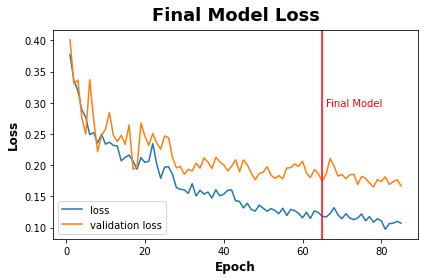

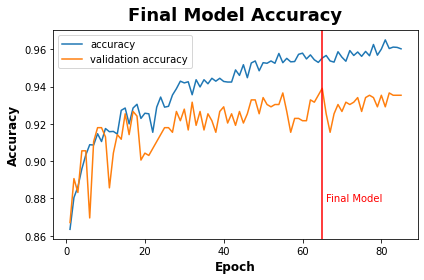

In order to assess its ability to predict the class on unseen data the model was evaluated using the model.evaluate function on the test dataset which showed an accuracy of 0.9407 and a loss of 0.1898. 

A confusion matrix was created using the models predictions of the test dataset in order to visualise differences between categories in prediction accuracy

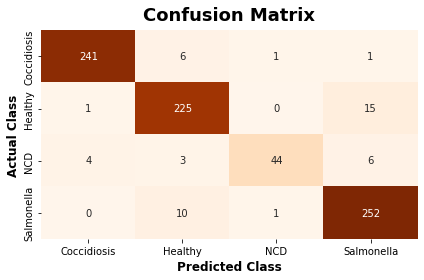

In [ ]:
# Generating final loss/accuracy figures and confusion matrix


# download model
!wget -O model.zip https://www.dropbox.com/s/t49w8rr9jm5a36d/Models.zip?dl=0

# unzip model
!unzip /content/model.zip

# Load model
model = tf.keras.models.load_model('/content/Models')

# calculate loss and accuracy of model using test dataset
loss, accuracy = model.evaluate(ds_test_)

# create predictions of test dataset
pred = model.predict(ds_test_)

# create vector of maximum probability giving model classification
pred_class = np.argmax(pred, axis = 1)

# create vector of classes of actual classes
y = np.concatenate([y for x, y in ds_test_], axis=0)

# create vector of actual class
actual_class = np.argmax(y, axis = 1)

# Create tuple of class categories
classes = ('Coccidiosis', 'Healthy', 'NCD', 'Salmonella')

# calculate confusion matrix 
confm = confusion_matrix(actual_class, pred_class)#, normalize = 'pred', 'all', 'true'
df_cm = DataFrame(confm, index=classes, columns=classes)

plt.figure(facecolor='white')
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g', cbar = False)
# add class labels
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label 
# being i-th class and predicted label being j-th class.

## 4. Discussion

A 94% accuracy in diagnosing disease in pictures of chicken faeces has the potential to provide a rapid diagnosis of disease. This would allow swift measures to be put in place to control the disease. As the accuracy of this test isn't perfect it would be sensible to implement this model as a screening test for disease which requires further conformatory testing.

The model training process may have yielded better results if a more formal hyperparameter seach method including an element of randomisation was included (Bergstra and Bengio, 2012) instead of the stepwise model hyperparameter determiniation ustilised in the development of this model. 

Image augmentation use could also have been tested to see which options to include would have yielded the best results. Furthermore to reduce the impact of the uneven data sizes before training the model, the smaller image categories could have been supplemented by using augmentation to generate new images.

There are other diseases that can cause changes to faeces in poutry which this model hasn't been trained on which would likely reduced the accuracy further. The imbalance in the dataset also has the potential to have impacted the training of the model.

The model that was trained has achived reasonable accuracy on images that it hasn't been trained on, although this must be tempered with the knowledge that the images in the test dataset are still from the same original dataset. In order to further test this model a new set of images should be gathered from other sources as at the minute it is possible that this model is only useful for diagnosing disease in chickens from the specific locations that these images were taken.

It is also possible that these images may include some other clues as to what disease is present such as features in the background that the model has been trained to identify but these features may not be present in images gathered from other management systems or countries.

In summary the model has reasonable accuracy on the images in this dataset and could be used as a screening test for some clinical diseases of chickens although further real world validation would be required before this could be relied on.

## 5. Literature

Bergstra, James & Bengio, Y.. (2012). Random Search for Hyper-Parameter Optimization. The Journal of Machine Learning Research. 13. 281-305. 

Brodzicki, A., Piekarski, M., Kucharski, D., Jaworek-Korjakowska, J. and Gorgon, M. (2020). Transfer Learning Methods as a New Approach in Computer Vision Tasks with Small Datasets. Foundations of Computing and Decision Sciences, 45(3), pp.179–193. doi:10.2478/fcds-2020-0010.

Mikołajczyk, A. and Grochowski, M. (2018). Data augmentation for improving deep learning in image classification problem. [online] IEEE Xplore. doi:10.1109/IIPHDW.2018.8388338.


Viloria, A., Pineda Lezama, O.B. and Mercado-Caruzo, N. (2020). Unbalanced data processing using oversampling: Machine Learning. Procedia Computer Science, [online] 175, pp.108–113. doi:10.1016/j.procs.2020.07.018.

‌
Quach, L.-D., Quoc, N.P., Thi, N.H., Le Thanh, N., Thanh, X.T.T., Tran, D.C. and Hassan, M.F. (2022). An AI-Based Chicken Disease Management System. International Conference on Artificial Intelligence for Smart Community, pp.707–716. doi:10.1007/978-981-16-2183-3_68.

‌